Import Library

In [58]:
import pandas as pd
import json
import re
import string
from nltk.tokenize import word_tokenize
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
import nltk
nltk.download('punkt')

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from imblearn.over_sampling import SMOTE

import joblib

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Administrator\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Load sumberdaya dan pendefinisian fungsi preprocessing untuk dataset model pelatihan

LINK REFERENSI
* stopwords : https://github.com/stopwords-iso/stopwords-id/blob/master/stopwords-id.txt
* kamus leksikon : https://github.com/onpilot/sentimen-bahasa/tree/master
* kamus bahasa indonesia : https://github.com/damzaky/kumpulan-kata-bahasa-indonesia-KBBI/blob/master/list_1.0.0.txt
* kamus slang : https://github.com/nasalsabila/kamus-alay/blob/master/colloquial-indonesian-lexicon.csv

In [54]:
factory = StemmerFactory()
stemmer = factory.create_stemmer()

def load_file(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        return set(file.read().splitlines())
    
def load_lexicon(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        return set(json.load(file))  
    
slang_dict = json.load(open("txt/kamusSlang.json", "r", encoding="utf-8"))
stopwords = load_file('txt/stopwords-1.txt')
kamus_indonesia = load_file('txt/kamusIndonesia.txt')
pos_lexicon = load_lexicon('leksikon/leksikon-pos.json')
neg_lexicon = load_lexicon('leksikon/leksikon-neg.json')

def preprocessing(text, slang_dict, stopwords, kamus_indonesia, stemmer):
    text = text.lower()  # Case folding
    text = re.sub(r"\\t|\\n|\\u|\\|http[s]?://\\S+|[@#][A-Za-z0-9_]+", " ", text)  # Menghapus karakter khusus
    text = re.sub(r"\\d+", "", text)  # Menghapus angka
    text = text.translate(str.maketrans("", "", string.punctuation))  # Menghapus tanda baca (pakai import string)
    text = re.sub(r"\\s+", ' ', text).strip()  # merapihkan spasi ganda
    text = re.sub(r"\b[a-zA-Z]\b", "", text) # Menghapus satu huruf (besar/kecil)
    text = ' '.join([slang_dict.get(word, word) for word in text.split()]) # Normalisasi (pemanfaatan kamus slang)
    text = word_tokenize(text) # Tokenisasi (sebelum stemming)
    text = [stemmer.stem(word) for word in text] # Stemming
    text = [word for word in text if word not in stopwords and len(word) > 3 and word in kamus_indonesia] # Stopwords & memilah kata
    text = ' '.join(text)
    return text


Fungsi pelabelan sentimen (boleh diskip)

In [ ]:
def hitung_sentimen(text, leksikon_positif, leksikon_negatif, prior_positif=0.5, prior_negatif=0.5):
    # skor total
    total_skor_positif = 0
    total_skor_negatif = 0

    # algoritma iterasi seluruh kata pada kalimat
    for kata in text.split():
        # perhitungan P(kata|positif) dan P(kata|negatif) dalam kamus jika ditemukan.
        probabilitas_kata_positif = 1 / len(leksikon_positif) if kata in leksikon_positif else 0
        probabilitas_kata_negatif = 1 / len(leksikon_negatif) if kata in leksikon_negatif else 0

        # jumlah skor kata yang ditemukan dalam kamus
        total_skor_kata = probabilitas_kata_positif + probabilitas_kata_negatif

        # perhitungan skor sentimen positif dan negatif untuk kata
        skor_sentimen_positif = probabilitas_kata_positif / total_skor_kata if total_skor_kata > 0 else 0
        skor_sentimen_negatif = probabilitas_kata_negatif / total_skor_kata if total_skor_kata > 0 else 0

        # penjumlahan skor positif dan negatif
        total_skor_positif += skor_sentimen_positif
        total_skor_negatif += skor_sentimen_negatif

    # menghitung total skor semua kata pada kalimat
    total_skor_semua = total_skor_positif + total_skor_negatif

    # menghitung probabilitas untuk sentimen positif dan negatif pada kalimat
    probabilitas_positif = ((total_skor_positif / total_skor_semua) * prior_positif) if total_skor_semua > 0 else 0
    probabilitas_negatif = ((total_skor_negatif / total_skor_semua) * prior_negatif) if total_skor_semua > 0 else 0

    # menentukan sentimen berdasarkan probabilitas sentimen tertinggi
    if probabilitas_positif > probabilitas_negatif:
        return 'Positif', 1
    elif probabilitas_negatif > probabilitas_positif:
        return 'Negatif', -1
    else:
        return 'Netral', 0

Pemanggilan fungsi preprocessing

In [ ]:
df = pd.read_csv('code_filter_crawling/crawling.csv')
df.rename(columns={"full_text" : "teks"}, inplace=True)
df['teks'] = df['teks'].apply(lambda x: preprocessing(x, slang_dict, stopwords, kamus_indonesia,stemmer))

df.to_csv('preprocessing/preprocessing.csv', index=False)
df = df[df['teks'].str.strip().astype(bool)]

Pemanggilan fungsi pelabelan (boleh di skip)

In [ ]:
df[['label' ,'skor']] = df['teks'].apply(lambda x: pd.Series(hitung_sentimen(x, pos_lexicon, neg_lexicon)))
df = df[df['teks'].str.strip().astype(bool)]
df.to_csv('dataset_berlabel/dataset_berlabel.csv', index=False)

Pengecekkan oversampling

In [ ]:
import pandas as pd
from collections import Counter
df = pd.read_csv('dataset_berlabel/dataset_berlabel.csv')

# 1. Hitung distribusi label
label_distribution = Counter(df['label'])
print("Distribusi Label:", label_distribution)

# 2. Periksa ketidakseimbangan
is_balanced = len(set(label_distribution.values())) == 1
if is_balanced:
    print("Dataset sudah seimbang. Tidak perlu oversampling.")
else:
    print("Dataset tidak seimbang. Oversampling dapat dipertimbangkan dengan menggunakan SMOTE")

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
df = df[['teks', 'label']]
sns.countplot(data=df, x='label', color='green')
plt.title('Distribusi Label')
plt.xlabel('Label')
plt.ylabel('Jumlah label')
plt.show()

Pelatihan model logistic regression (tanpa SMOTE)

In [59]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

data = pd.read_csv('dataset_berlabel/dataset_berlabel.csv')

X = data['teks']
y = data['label']

# split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# vektorisasi
vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# melatih model Logistic Regression
model = LogisticRegression()
model.fit(X_train_tfidf, y_train)

# memprediksi hasil untuk data training dan testing
y_train_pred = model.predict(X_train_tfidf)
y_test_pred = model.predict(X_test_tfidf)

# evaluasi model pada data training & testing
print("Akurasi Traning:", accuracy_score(y_train, y_train_pred))
print("Akurasi Testing:", accuracy_score(y_test, y_test_pred))

# classification report untuk data testing
print("Classification Report:\n", classification_report(y_test, y_test_pred))

Akurasi Traning: 0.9368318756073858
Akurasi Testing: 0.8260869565217391
Classification Report:
               precision    recall  f1-score   support

     Negatif       0.81      0.96      0.88        75
      Netral       0.00      0.00      0.00         3
     Positif       0.88      0.62      0.73        37

    accuracy                           0.83       115
   macro avg       0.56      0.53      0.54       115
weighted avg       0.81      0.83      0.81       115



c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

# presisi, recall, dan f1-score secara keseluruhan
precision = precision_score(y_test, y_test_pred, average='macro')
recall = recall_score(y_test, y_test_pred, average='macro')
f1 = f1_score(y_test, y_test_pred, average='macro')

print(f"Presisi (keseluruhan): {precision:.2f}")
print(f"Recall (keseluruhan): {recall:.2f}")
print(f"F1-Score (keseluruhan): {f1:.2f}")


Presisi (keseluruhan): 0.56
Recall (keseluruhan): 0.53
F1-Score (keseluruhan): 0.54


c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Pelatihan model logistic regression (menggunakan SMOTE) proporsi split data 70:30

In [62]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
import joblib

df = pd.read_csv('dataset_berlabel/dataset_berlabel.csv')
X = df['teks']
y = df['label']

# split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# vektorisasi
vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# SMOTE
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_tfidf, y_train)

# melatih model Logistic Regression
model = LogisticRegression()
model.fit(X_train_smote, y_train_smote)

# memprediksi hasil data training dan testing
y_train_pred = model.predict(X_train_smote)
y_pred = model.predict(X_test_tfidf)

# evaluasi model training & testing
print("Akurasi Training:", accuracy_score(y_train_smote, y_train_pred))
print("Akurasi Testing:", accuracy_score(y_test, y_pred))

# classification untuk data testing
print("Classification Report:\n", classification_report(y_test, y_pred))

# Simpan model dan vectorizer
joblib.dump(model, "model/model_sentimen.pkl")
joblib.dump(vectorizer, "model/vectorizer_sentimen.pkl")

Akurasi Training: 0.9835390946502057
Akurasi Testing: 0.8343023255813954
Classification Report:
               precision    recall  f1-score   support

     Negatif       0.86      0.89      0.87       208
      Netral       0.36      0.29      0.32        14
     Positif       0.83      0.80      0.82       122

    accuracy                           0.83       344
   macro avg       0.68      0.66      0.67       344
weighted avg       0.83      0.83      0.83       344



['model/vectorizer_sentimen.pkl']

In [64]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Menghitung presisi, recall, dan F1-score secara keseluruhan
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

print(f"Presisi (keseluruhan): {precision:.2f}")
print(f"Recall (keseluruhan): {recall:.2f}")
print(f"F1-Score (keseluruhan): {f1:.2f}")


Presisi (keseluruhan): 0.68
Recall (keseluruhan): 0.66
F1-Score (keseluruhan): 0.67


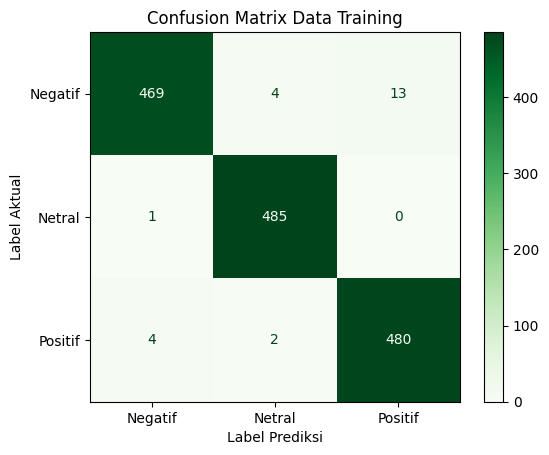

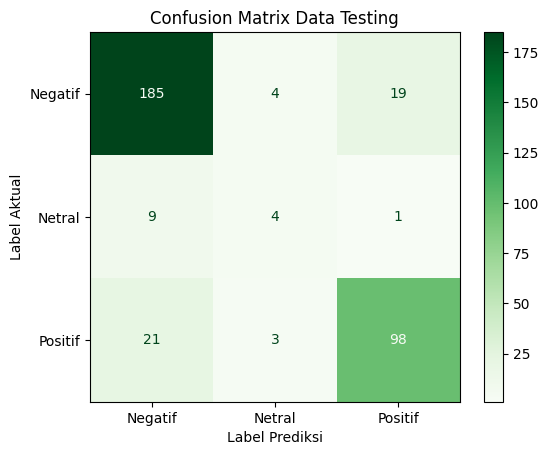

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
# fungsi menghitung confusion matrix
cmtrain = confusion_matrix(y_train_smote, y_train_pred)
cmtest = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cmtrain, display_labels=model.classes_)
disp.plot(cmap="Greens")
plt.xlabel("Label Prediksi")
plt.ylabel("Label Aktual")
plt.title("Confusion Matrix Data Training")
plt.show()

disp = ConfusionMatrixDisplay(confusion_matrix=cmtest, display_labels=model.classes_)
disp.plot(cmap="Greens")
plt.xlabel("Label Prediksi")
plt.ylabel("Label Aktual")
plt.title("Confusion Matrix Data Testing")
plt.show()